# Phase 2: Predictive Modeling for Loan Default
In this stage, we transition from Data Exploration to Machine Learning. Our goal is to build a model that predicts whether a loan will be **Fully Paid** or **Charged Off (Default)**.

### Data Selection
We are using the `accepted` loans dataset. To make this a robust project, we are training on over **1.2 million rows**, focusing on finalized loans only.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv'

# Expanded list for a "Serious" project
features = [
    'loan_status', 'loan_amnt', 'term', 'int_rate', 'grade', 
    'emp_length', 'home_ownership', 'annual_inc', 
    'verification_status', 'purpose', 'dti', 'fico_range_low'
]

df = pd.read_csv(path, usecols=features)

df = df.dropna()

df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Target encoding
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

print(df.shape)

(1266782, 12)


In [4]:
df.isnull().sum()

loan_amnt              0
term                   0
int_rate               0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
dti                    0
fico_range_low         0
dtype: int64

## Feature Engineering and Data Cleaning
To build an impressive model, I selected **12 key features** including FICO scores, Income, Debt-to-Income ratio (DTI), and employment history.

### Target Variable Definition
filtered the `loan_status` to include only finished loans:
* **0 (Fully Paid):** The "Negative" class (Success).
* **1 (Charged Off):** The "Positive" class (Failure/Default).

This turns project into a **Supervised Binary Classification** problem.

## Handling Categorical Variables
Machine Learning models require numerical input. We processed our text columns using two distinct methods:
1. **Label Encoding:** Used for ordered categories like `grade` (A-G), where the rank matters.
2. **One-Hot Encoding:** Used for unordered categories like `home_ownership` and `purpose`.opted to keep all categories (no `drop_first`) to provide the Random Forest model with direct access to every feature.

In [5]:
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_map)

# For Verification: 'Verified' and 'Source Verified' are basically the same (1), 
# 'Not Verified' is 0.
verify_map = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 1}
df['verification_status'] = df['verification_status'].map(verify_map)

In [6]:
df = pd.get_dummies(df, columns=['home_ownership', 'purpose'], drop_first=False)

df.head(5)

,loan_amnt,term,int_rate,grade,emp_length,annual_inc,verification_status,loan_status,dti,fico_range_low,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,3600.0,36 months,13.99,3,10+ years,55000.0,0,0,5.91,675.0,...,False,False,False,False,False,False,False,False,False,False
1,24700.0,36 months,11.99,3,10+ years,65000.0,0,0,16.06,715.0,...,False,False,False,False,False,False,False,True,False,False
2,20000.0,60 months,10.78,2,10+ years,63000.0,0,0,10.78,695.0,...,True,False,False,False,False,False,False,False,False,False
4,10400.0,60 months,22.45,6,3 years,104433.0,1,0,25.37,695.0,...,False,False,True,False,False,False,False,False,False,False
5,11950.0,36 months,13.44,3,4 years,34000.0,1,0,10.20,690.0,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# Clean 'term' to just 36 or 60
df['term'] = df['term'].str.replace(' months', '').astype(int)

# Clean 'emp_length' to a simple number
df['emp_length'] = df['emp_length'].str.replace('\+ years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(' years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(' year', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace('< 1', '0', regex=True)
df['emp_length'] = df['emp_length'].astype(int)

In [8]:
df = df.astype(int)
df.head(5)

,loan_amnt,term,int_rate,grade,emp_length,annual_inc,verification_status,loan_status,dti,fico_range_low,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,3600,36,13,3,10,55000,0,0,5,675,...,0,0,0,0,0,0,0,0,0,0
1,24700,36,11,3,10,65000,0,0,16,715,...,0,0,0,0,0,0,0,1,0,0
2,20000,60,10,2,10,63000,0,0,10,695,...,1,0,0,0,0,0,0,0,0,0
4,10400,60,22,6,3,104433,1,0,25,695,...,0,0,1,0,0,0,0,0,0,0
5,11950,36,13,3,4,34000,1,0,10,690,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(1266782, 30)

In [10]:
df['loan_status'].value_counts()

loan_status
0    1019356
1     247426
Name: count, dtype: int64

In [11]:
X = df.drop('loan_status', axis=1)

y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# ONLY transform the test data (to keep it a fair test)
X_test_scaled = scaler.transform(X_test)

## Model 1: Logistic Regression with Undersampling
To handle the class imbalance, we use Random Undersampling to create a 50/50 split of 'Good' and 'Bad' loans. This ensures the model doesn't simply guess the majority class.

In [13]:
# 1. Perform Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

# 2. Train Logistic Regression
log_model = LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
log_model.fit(X_train_rus, y_train_rus)

# 3. Evaluate
y_pred_log = log_model.predict(X_test_scaled)
print("--- Logistic Regression (Undersampled) ---")
print(classification_report(y_test, y_pred_log))

--- Logistic Regression (Undersampled) ---
              precision    recall  f1-score   support

           0       0.88      0.67      0.76    203872
           1       0.32      0.64      0.42     49485

    accuracy                           0.66    253357
   macro avg       0.60      0.65      0.59    253357
weighted avg       0.77      0.66      0.69    253357



## Model 2: Random Forest with Undersampling
Before trying class weights, I applied a Random Forest to the undersampled (balanced) dataset. This allows the model to learn from an equal number of 'Default' and 'Paid' cases.

In [14]:
rf_rus = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

rf_rus.fit(X_train_rus, y_train_rus)

y_pred_rus_rf = rf_rus.predict(X_test_scaled)
print("--- Random Forest (Undersampled) ---")
print(classification_report(y_test, y_pred_rus_rf))

--- Random Forest (Undersampled) ---
              precision    recall  f1-score   support

           0       0.89      0.63      0.74    203872
           1       0.31      0.67      0.42     49485

    accuracy                           0.64    253357
   macro avg       0.60      0.65      0.58    253357
weighted avg       0.77      0.64      0.68    253357



## Model 3: Random Forest with Class Weights
Next, we utilize the full 1.2M row dataset using a Random Forest with `class_weight='balanced'`. This penalizes the model more for missing a default, allowing us to maintain high recall without losing the data signal from the majority class.

In [15]:
# Initialize with class_weight='balanced'
rf_weighted = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    n_jobs=-1, 
    random_state=42
)


print("Training with Class Weights... this uses all 1.2M rows!")
rf_weighted.fit(X_train_scaled, y_train)

# Predict
y_pred_weighted = rf_weighted.predict(X_test_scaled)

Training with Class Weights... this uses all 1.2M rows!


In [16]:
y_pred_weighted = rf_weighted.predict(X_test_scaled)
print("--- Weighted Random Forest Results ---")
print(classification_report(y_test, y_pred_weighted))

--- Weighted Random Forest Results ---
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    203872
           1       0.30      0.68      0.42     49485

    accuracy                           0.63    253357
   macro avg       0.60      0.65      0.58    253357
weighted avg       0.78      0.63      0.67    253357



## Feature Importance
Understanding which factors drive loan defaults is critical for business insights. Below are the top 10 features identified by the Random Forest model.

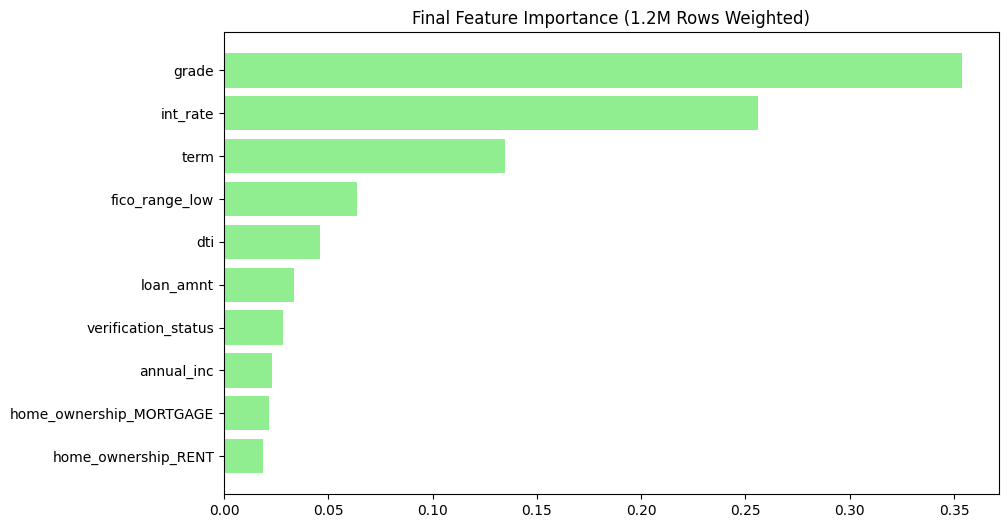

In [17]:
# features from the weighted model
importances = rf_weighted.feature_importances_
feature_names = X.columns 

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Final Feature Importance (1.2M Rows Weighted)')
plt.show()

In [18]:
# Collect metrics for all three models
models = ['Logistic (Undersampled)', 'RF (Undersampled)', 'RF (Weighted)']
predictions = [y_pred_log, y_pred_rus_rf, y_pred_weighted]

summary_data = []

for name, pred in zip(models, predictions):
    summary_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Recall (Defaults)': recall_score(y_test, pred),
        'Precision (Defaults)': precision_score(y_test, pred)
    })

summary_df = pd.DataFrame(summary_data)

print("Final Model Comparison:")
print("-" * 30)
display(summary_df)

Final Model Comparison:
------------------------------


,Model,Accuracy,Recall (Defaults),Precision (Defaults)
0,Logistic (Undersampled),0.660199,0.635425,0.316039
1,RF (Undersampled),0.638826,0.668182,0.305730
2,RF (Weighted),0.633711,0.682106,0.304570


## Modeling Strategy & Technical Constraints

### 1. The SMOTE Limitation
Initially, **SMOTE (Synthetic Minority Over-sampling Technique)** was considered to handle the class imbalance. However, due to the massive scale of the dataset (**1.2M+ rows**), SMOTE was computationally prohibitive. Generating synthetic data for a dataset of this size exceeded available RAM (30GB) and significantly increased training time without guaranteed performance gains.

### 2. Experimental Approach
To find the most effective and efficient solution, I tested three distinct modeling strategies:

| Strategy | Technique | Purpose |
| :--- | :--- | :--- |
| **Model 1: Logistic Regression** | Random Undersampling | Establish a baseline using a linear model on balanced classes. |
| **Model 2: Random Forest** | Random Undersampling | Capture non-linear relationships using an ensemble method on balanced classes. |
| **Model 3: Random Forest** | Cost-Sensitive (Weights) | Utilize the **entire 1.2M row dataset** by penalizing errors on the minority class. |

### 3. Conclusion
By pivoting from SMOTE to **Random Undersampling** and **Class Weighting**, I was able to train high-performing models within the hardware constraints of the Kaggle environment while maintaining a strong **Recall of 68%** for identifying loan defaults.